In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import annotations
c = 299792458 # speed of light in m/s

In [5]:
df = pd.read_excel('Datos/Aldebaran_pepsi.xlsx', sheet_name='Aldebaran_pepsi')
df.to_csv('Datos/Aldebaran_pepsi.csv', index=False)
iron = pd.read_excel('Datos/Nave_table_2.xlsx', sheet_name='A', usecols="F")
iron.to_csv('Datos/Nave.csv', index=False)

In [16]:
# Devuelve los índices i que cumplen con la condicion discreta de mínimo local: y[i-1] > y[i] < y[i+1]
def detect_discrete_minima_candidates(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y)
    if y.size < 3:
        return np.array([], dtype=int)
    cond = (y[1:-1] < y[0:-2]) & (y[1:-1] < y[2:])
    return np.nonzero(cond)[0] + 1


# Ajusta un polinomio de grado 'degree' a los puntos (x_win, y_win) y refina la posición del mínimo local alrededor del punto x_center (candidato discreto). 
# Da información de la curvatura y si el mínimo es válido.
def _fit_poly_and_refine_min(x_win, y_win, degree, x_center):
    # Centrar x para mejorar la condición numérica
    x_shift = x_win - x_center
    coeffs = np.polyfit(x_shift, y_win, deg=degree)
    p = np.poly1d(coeffs)

    dp = p.deriv(1)
    d2p = p.deriv(2)
    d3p = p.deriv(3)

    # Raíces de la primera derivada (en el sistema centrado)
    roots = np.roots(dp)
    roots = roots[np.isclose(roots.imag, 0, atol=1e-12)].real

    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan, np.nan

    # Limitar raíces al rango de la ventana centrada
    x_min, x_max = x_shift.min(), x_shift.max()
    roots = roots[(roots >= x_min) & (roots <= x_max)]
    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan, np.nan

    # Elegir la raíz más cercana al candidato (en coordenadas centradas)
    root_shift = roots[np.argmin(np.abs(roots - 0))]  # 0 porque centramos en x_center
    x_star = x_center + root_shift  # volver a coordenadas originales
    y_star = p(root_shift)

    second_deriv = d2p(root_shift)   # segunda derivada
    third_deriv = d3p(root_shift)  # tercera derivada
    is_min = second_deriv > 0

    return float(x_star), float(y_star), True, bool(is_min), float(second_deriv), float(third_deriv)



# Encuentra mínimos locales en los datos (x, y) ajustando polinomios en ventanas alrededor de los candidatos discretos.
def find_local_minima_polyfit(
    x: np.ndarray,
    y: np.ndarray,
    window_pts: int = 15,
    degree: int = 4,
    min_points: int = None,
    min_curvature: float = 20,
    max_slope: float = 1000,
) -> pd.DataFrame:

    if window_pts < degree + 1:
        raise ValueError("window_pts debe ser al menos degree+1.")
    if min_points is None:
        min_points = degree + 1
    if min_points < degree + 1:
        raise ValueError("min_points debe ser >= degree+1.")

    n = len(x)
    half = window_pts // 2
    candidates = detect_discrete_minima_candidates(y)
    rows = []

    for i in candidates:
        start = max(0, i - half)
        end = min(n, start + window_pts)
        start = max(0, end - window_pts)

        x_win = x[start:end]
        y_win = y[start:end]

        if x_win.size < min_points:
            rows.append({
                "idx_candidate": int(i),
                "x_refined": np.nan,
                "y_refined": np.nan,
                "second_deriv": np.nan,
                "curvature": np.nan,
                "third_deriv": np.nan,
                "slope": np.nan,
                "valid_minimum": False,
            })
            continue

        try:
            x_star, y_star, root_in_window, is_min, second_deriv, third_deriv = _fit_poly_and_refine_min(
                x_win, y_win, degree, x_center=x[i]
            )
        except np.linalg.LinAlgError:
            x_star, y_star, root_in_window, is_min, second_deriv, third_deriv = np.nan, np.nan, False, False, np.nan

        # Calcular curvatura y pendiente de la bisectriz
        
        #curvature = second_deriv * x_star**2
        curvature = second_deriv
        slope = (-c*third_deriv)/(3*x_star*(second_deriv**2))

        depth = (np.median(y_win) - y_star) / np.median(y_win)
        #valid = is_min and curvature > 0 and depth > 0.05


        valid = bool(is_min and 
                     curvature >= min_curvature and
                     abs(slope) <= max_slope)

        rows.append({
            "idx_candidate": int(i),
            "x_refined": x_star,
            "y_refined": y_star,
            "second_deriv": second_deriv,  
            "curvature": curvature,
            "third_deriv": third_deriv,
            "slope": slope,
            "valid_minimum": valid
        })

    return pd.DataFrame(rows)



In [ ]:
df = pd.read_csv('Datos/Aldebaran_pepsi.csv')


x = df.iloc[:,0]  # primera columna
y = df.iloc[:,1]  # segunda columna


df_min = find_local_minima_polyfit(x, y, window_pts=15, degree=4)
df_min = df_min[df_min["valid_minimum"]]
#df_min = df_min[df_min["x_refined"] > 0]

#df_min.to_csv("Datos/df_min.csv", index=False)

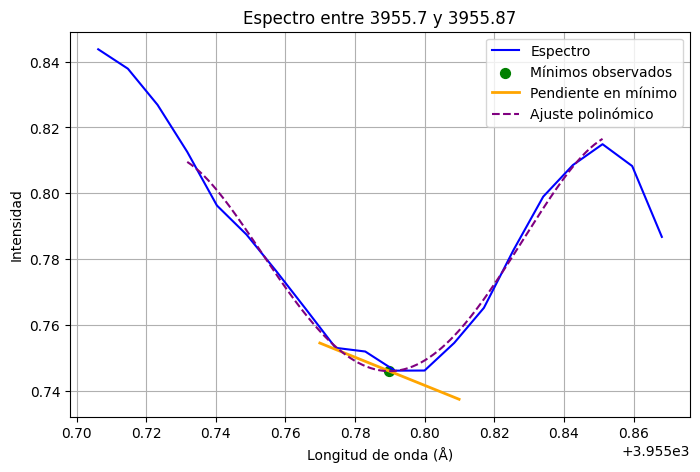

In [28]:
# Rango de interés
x1 = 3955.7
x2 = 3955.87

# Filtrar espectro en el rango dado
mask = (x >= x1) & (x <= x2)
x_range = x[mask]
y_range = y[mask]
window_pts = 15

# Leer archivo CSV con líneas teóricas
iron_lines = pd.read_csv("Datos/Nave.csv", header=None)[0]

# Filtrar solo las líneas dentro del rango
iron_in_range = iron_lines[(iron_lines >= x1) & (iron_lines <= x2)]

# Filtrar df_min en el rango
df_min_range = df_min[(df_min["x_refined"] >= x1) & (df_min["x_refined"] <= x2)]

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x_range, y_range, label="Espectro", color="blue")

# Dibujar líneas verticales en posiciones teóricas
for i, wl in enumerate(iron_in_range):
    plt.axvline(wl, color="red", linestyle="--", alpha=0.7,
                label="Líneas de Fe (teóricas)" if i == 0 else "")
    plt.text(wl, max(y_range)*0.95, f"{wl:.2f}", rotation=90,
             verticalalignment="top", horizontalalignment="right", fontsize=8, color="red")

# Graficar los mínimos observados (x_refined, y_refined)
plt.scatter(df_min_range["x_refined"], df_min_range["y_refined"], 
            color="green", marker="o", s=50, label="Mínimos observados")

# === Graficar tangentes (pendientes) en cada mínimo ===
dx = 0.02  # ancho en Å para la línea tangente
scale = 0.001  # factor de escala para que las pendientes no tapen el espectro

for i, row in df_min_range.iterrows():
    x0, y0, slope = row["x_refined"], row["y_refined"], row["slope"]

    # Puntos extremos de la recta tangente (escalada)
    x_vals = [x0 - dx, x0 + dx]
    y_vals = [y0 - slope * dx * scale, y0 + slope * dx * scale]

    plt.plot(x_vals, y_vals, color="orange", linewidth=2, 
             label="Pendiente en mínimo" if i == df_min_range.index[0] else "")
    
# === Graficar polinomio ajustado en cada mínimo ===
for i, row in df_min_range.iterrows():
    idx = int(row["idx_candidate"])
    
    # Definir ventana alrededor del mínimo (igual que en el ajuste)
    half = window_pts // 2
    start = max(0, idx - half)
    end = min(len(x), start + window_pts)
    start = max(0, end - window_pts)

    x_win = x[start:end]
    y_win = y[start:end]

    # Ajustar el polinomio otra vez en esa ventana
    x_shift = x_win - x[idx]
    coeffs = np.polyfit(x_shift, y_win, deg=4)
    p = np.poly1d(coeffs)

    # Evaluar en un rango denso para trazar curva suave
    x_dense = np.linspace(x_win.min(), x_win.max(), 200)
    y_dense = p(x_dense - x[idx])  # ojo: restamos el shift

    # Dibujar polinomio con línea punteada
    plt.plot(x_dense, y_dense, "--", color="purple", linewidth=1.5,
             label="Ajuste polinómico" if i == df_min_range.index[0] else "")


plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Intensidad")
plt.title(f"Espectro entre {x1} y {x2}")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
tol = 0.1
matches = []

for theo in iron.iloc[:, 0]:
    nearby = df_min[(df_min["x_refined"].notna()) & 
                    (abs(df_min["x_refined"] - theo) <= tol)]
    if not nearby.empty:
        # Seleccionar el match con menor diferencia
        obs = nearby.iloc[(nearby["x_refined"] - theo).abs().argmin()]
        matches.append({
            "lambda_theo": theo,
            "lambda_obs": obs["x_refined"],
            "y_obs": obs["y_refined"],
            "delta": obs["x_refined"] - theo,
            "curvature": obs["second_deriv"],
            "slope": obs["slope"]
        })

df_matches = pd.DataFrame(matches) 
df_matches = df_matches.drop_duplicates(subset=["lambda_obs"], keep="first")
print(df_matches)

     lambda_theo   lambda_obs     y_obs     delta   curvature       slope
0      3953.1514  3953.154887  0.316196  0.003487  201.564565  471.849151
1      3955.3413  3955.335611  0.341159 -0.005689  181.248923 -945.992353
2      3955.9555  3955.956386  0.368267  0.000886  201.153585  987.015396
3      3957.0184  3957.046204  0.155937  0.027804  120.592963 -842.006668
4      3963.1005  3963.106312  0.383668  0.005812   70.882152  402.943993
..           ...          ...       ...       ...         ...         ...
643    9100.6748  9100.656589  0.631174 -0.018211   41.248487 -613.328754
644    9103.6375  9103.626160  0.728207 -0.011340   33.625340  197.281061
645    9117.1327  9117.140957  0.066899  0.008257   71.292582  -97.018572
646    9118.8816  9118.883521  0.351210  0.001921   36.403051  164.799783
647    9119.9705  9119.919455  0.824575 -0.051045   23.742299  781.744729

[638 rows x 6 columns]


In [20]:
df_matches["velocity_ms"] = c * (df_matches["delta"]) / df_matches["lambda_theo"]

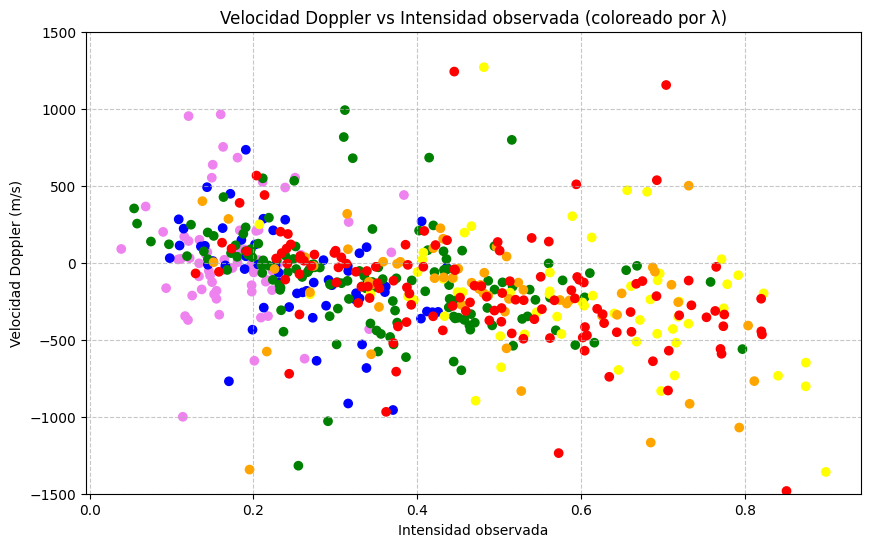

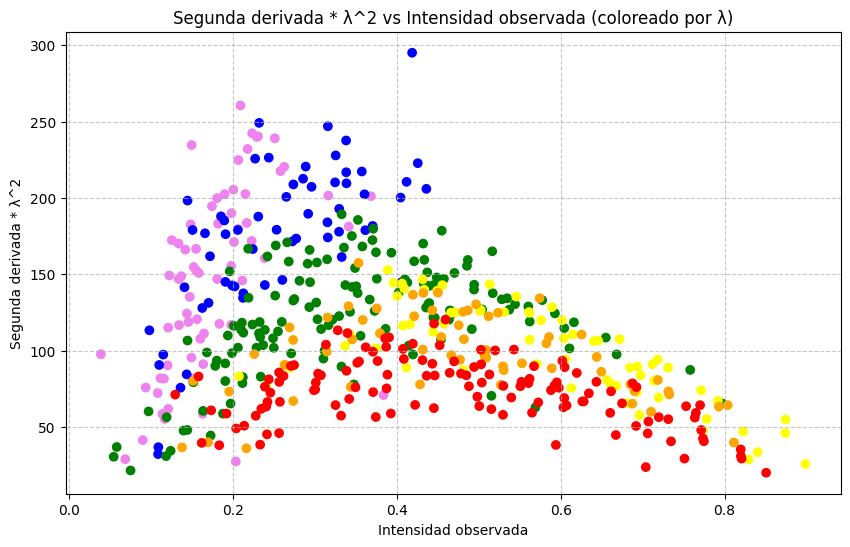

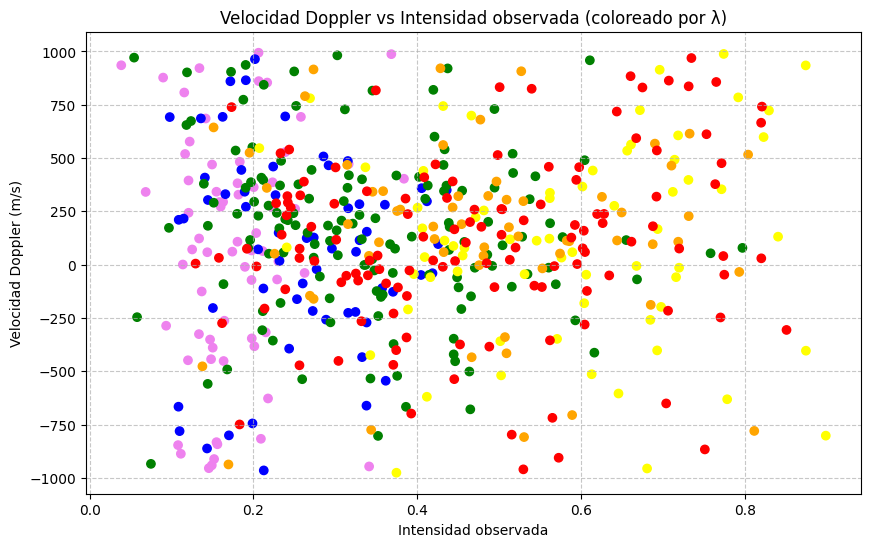

In [25]:
def wavelength_to_color(wl):
    if 3800 <= wl < 4500:
        return "violet"
    elif 4500 <= wl < 4950:
        return "blue"
    elif 4950 <= wl < 5700:
        return "green"
    elif 5700 <= wl < 5900:
        return "yellow"
    elif 5900 <= wl < 6200:
        return "orange"
    elif 6200 <= wl <= 7500:
        return "red"
    else:
        return "gray"  # fuera del rango visible

# Crear columnas de colores
df_matches["Color"] = df_matches["lambda_obs"].apply(wavelength_to_color)
# Filtrar para eliminar los puntos grises
df_visible = df_matches[df_matches["Color"] != "gray"]


# Grafico de Velocidad Doppler vs Intensidad observada, coloreado por longitud de onda
# Gráfico en Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(
    df_visible["y_obs"], 
    df_visible["velocity_ms"], 
    c=df_visible["Color"]
)

plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (m/s)")
plt.ylim(-1500, 1500)
plt.title("Velocidad Doppler vs Intensidad observada (coloreado por λ)")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()


# Gráfico de curvatura (segunda derivada * λ^2) vs Intensidad observada
# Gráfico en Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(
    df_visible["y_obs"], 
    df_visible["curvature"], 
    c=df_visible["Color"]
)

plt.ylabel("Segunda derivada * λ^2")
plt.xlabel("Intensidad observada")
plt.title("Segunda derivada * λ^2 vs Intensidad observada (coloreado por λ)")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()


# Gráfico de pendiente vs Intensidad observada
# Gráfico en Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(
    df_visible["y_obs"], 
    df_visible["slope"], 
    c=df_visible["Color"]
)
plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (m/s)")
#plt.ylim(-20000,20000)
plt.title("Velocidad Doppler vs Intensidad observada (coloreado por λ)")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()


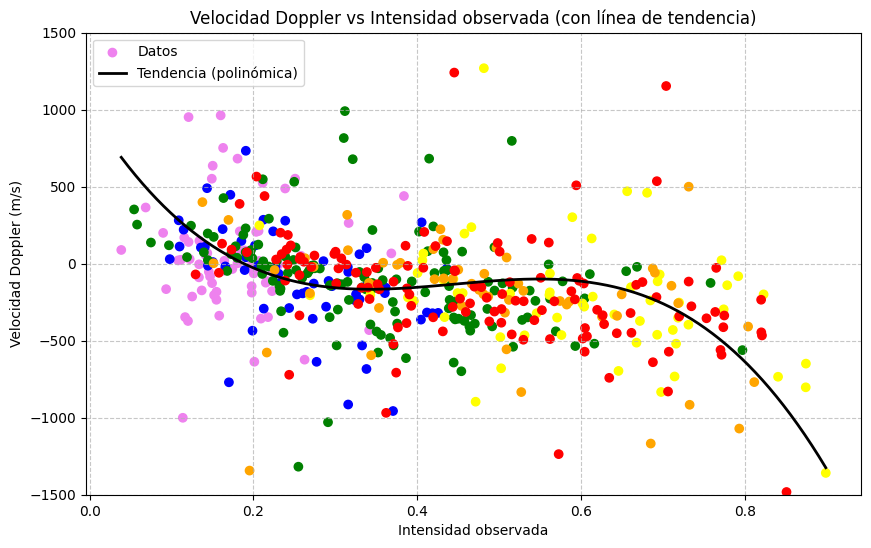

In [29]:
import numpy as np

# Ajuste polinómico (ejemplo: grado 3, puedes variar)
x = df_visible["y_obs"].values
y = df_visible["velocity_ms"].values

# Ordenar por x para trazar bien la curva
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y[order]

# Ajuste polinomial
coeffs = np.polyfit(x_sorted, y_sorted, deg=3)
poly = np.poly1d(coeffs)

# Curva ajustada
x_fit = np.linspace(x_sorted.min(), x_sorted.max(), 500)
y_fit = poly(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=df_visible["Color"], label="Datos")
plt.plot(x_fit, y_fit, "k-", linewidth=2, label="Tendencia (polinómica)")
plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (m/s)")
plt.ylim(-1500, 1500)
plt.title("Velocidad Doppler vs Intensidad observada (con línea de tendencia)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()